In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

<IPython.core.display.Javascript object>

In [26]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

In [3]:
med = pd.read_csv("physician-visits.csv")

<IPython.core.display.Javascript object>

Description of variable [here](https://rdrr.io/rforge/Ecdat/man/OFP.html)

In [4]:
rename_map = {
    "ofp": "n_phys_visits",
    "ofnp": "n_non_phys_visits",
    "opp": "n_phys_outpatient",
    "opnp": "n_non_phys_outpatient",
    "emr": "n_er_visits",
    "hosp": "n_hosp_visits",
    "numchron": "n_chronic_cond",
    "adldiff": "has_limiting_cond",
    "faminc": "family_income",
    "privins": "prvt_ins",
    "hlth": "health",
}


<IPython.core.display.Javascript object>

In [5]:
med = med.replace({"yes": 1, "no": 0})
med = med.rename(columns=rename_map)

<IPython.core.display.Javascript object>

In [6]:
med.head()

,Unnamed: 0,n_phys_visits,n_non_phys_visits,n_phys_outpatient,n_non_phys_outpatient,n_er_visits,n_hosp_visits,n_chronic_cond,has_limiting_cond,age,black,sex,maried,school,family_income,employed,prvt_ins,medicaid,region,health
0,1,5,0,0,0,0,1,2,0,6.9,1,male,1,6,2.8810,1,1,0,other,other
1,2,1,0,2,0,2,0,2,0,7.4,0,female,1,10,2.7478,0,1,0,other,other
2,3,13,0,0,0,3,3,4,1,6.6,1,female,0,10,0.6532,0,0,1,other,poor
3,4,16,0,5,0,1,1,2,1,7.6,0,male,1,3,0.6588,0,1,0,other,poor
4,5,3,0,0,0,0,0,2,1,7.9,0,female,1,6,0.6588,0,1,0,other,other


<IPython.core.display.Javascript object>

In [7]:
med.shape

(4406, 20)

<IPython.core.display.Javascript object>

In [8]:
med.isna().sum().sum()
# No na entire df

0

<IPython.core.display.Javascript object>

Does level of `'health'` relate to `'family_income'`

In [9]:
med[["health", "family_income"]].dtypes

health            object
family_income    float64
dtype: object

<IPython.core.display.Javascript object>

In [10]:
med["health"].value_counts()

other        3509
poor          554
excellent     343
Name: health, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
med.groupby("health").agg({"family_income": ["mean", "median"]})

family_income        
                   mean  median
health                         
excellent      3.277411  2.2719
other          2.551990  1.7469
poor           1.905162  1.1988

<IPython.core.display.Javascript object>

In [12]:
# TODO: Follow up on what 'other' is?
# can it include potentially excellent/poor health participants?
# Is it exclusively meaning 'not excellent or poor'

<IPython.core.display.Javascript object>

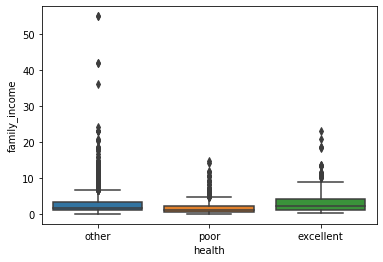

<IPython.core.display.Javascript object>

In [37]:
# TODO: should we keep what looks to be 3 income outliers
# in the other category? Is it only 3 above 30?
# Other is a big group, we're not data poor, consider how dropping
# would affect the analysis

sns.boxplot("health", "family_income", data=med)

In [ ]:
sns.violinplot("health", "family_income", data=med)
plt.show()

We have 3 groups, so we might ANOVA. We need to check assumptions

* Continuous? Yep
* Independent? Yep
* Normal?

In [14]:
other = med[med["health"] == "other"]
poor = med[med["health"] == "poor"]
excellent = med[med["health"] == "excellent"]

<IPython.core.display.Javascript object>

In [15]:
# TODO: come back and re-evaluate if dropping 0s is a good idea
# for now, dropping to investigate if log transform is a good idea

# (med["family_income"] == 0).sum()
# Result: 18 records

#TODO: for now, going to proceed with a non-parametric test

med = med[med["family_income"] > 0]

<IPython.core.display.Javascript object>

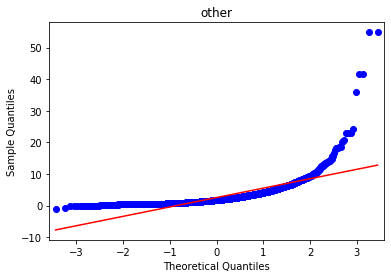

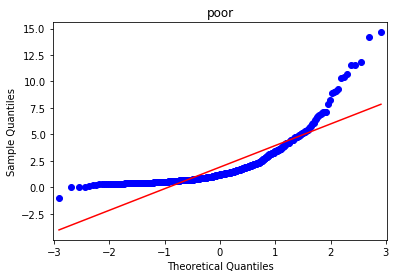

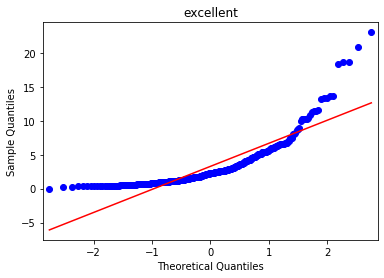

<IPython.core.display.Javascript object>

In [16]:
sm.qqplot(other["family_income"], line="s")
plt.title("other")
plt.show()

sm.qqplot(poor["family_income"], line="s")
plt.title("poor")
plt.show()

sm.qqplot(excellent["family_income"], line="s")
plt.title("excellent")
plt.show()

In [20]:
_, p = stats.kruskal(
    other["family_income"], poor["family_income"], excellent["family_income"]
)

reject = p < 0.05
reject

True

<IPython.core.display.Javascript object>

In [ ]:
alpha = 0.05



In [22]:
_, p1 = stats.kruskal(other["family_income"], poor["family_income"])

_, p2 = stats.kruskal(other["family_income"], excellent["family_income"])

_, p3 = stats.kruskal(poor["family_income"], excellent["family_income"])

<IPython.core.display.Javascript object>

In [25]:
multipletests([p1, p2, p3])

reject, corrected_p, _, _ = multipletests([p1, p2, p3])

reject

array([ True,  True,  True])

<IPython.core.display.Javascript object>

In [33]:
cles = cles_ind(other["family_income"], poor["family_income"])

print(f'poor health median income:{poor["family_income"].median()}')
print(f'other health median income:{other["family_income"].median()}')
print("-----------")
print(f"effect size{cles}")

poor health median income:1.1988
other health median income:1.7469
-----------
effect size0.6076489233975965


<IPython.core.display.Javascript object>

In [34]:
cles = cles_ind(other["family_income"], excellent["family_income"])


print(f'other health median income:{other["family_income"].median()}')
print(f'excellent health median income:{excellent["family_income"].median()}')
print("-----------")
print(f"effect size{cles}")

other health median income:1.7469
excellent health median income:2.2719
-----------
effect size0.5634549060433521


<IPython.core.display.Javascript object>

In [35]:
cles = cles_ind(poor["family_income"], excellent["family_income"])

print(f'poor health median income:{poor["family_income"].median()}')
print(f'excellent health median income:{excellent["family_income"].median()}')
print("-----------")
print(f"effect size{cles}")

poor health median income:1.1988
excellent health median income:2.2719
-----------
effect size0.6581501089347549


<IPython.core.display.Javascript object>